In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as op
import shutil
from zipfile import ZipFile
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from utils import get_image_paths, word_from_image_path, preprocess_image, print_im, TextTransform, N_CHARS, SEQUENCE_LENGTH, IMAGE_DIMENSIONS
from utils import NgramTransform, load_trained_CNN_weights, base_cnn_in_keras, plot_batch_images
from multi_gpu import make_parallel
import time 
import datetime
from keras.models import load_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
char_model = load_model("cnn_trained.h5")
n_grams_model = load_model("n_grams_model_final.h5")

### Building Joint Model

In [10]:
input_ = char_model.layers[0].input
print(input_.get_shape())

(?, 32, 100, 1)


In [6]:
# importing test_files
import pickle
with open('x_test.pickle', 'rb') as f:
    x_test = pickle.load(f)
with open('y_test.pickle', 'rb') as f:
    y_test = pickle.load(f)

In [365]:
x_batch = x_test[:1].reshape((1,)+IMAGE_DIMENSIONS+ (1,))
y_batch = y_test[:1]

In [366]:
# predictions 
cnn_pred = char_model.predict(x_batch)
n_grams_pred = n_grams_model.predict(x_batch)

In [367]:
cnn_pred.shape, n_grams_pred.shape

((1, 23, 37), (1, 10000))

### Beam Search

In [368]:
x_batch.shape

(1, 32, 100, 1)

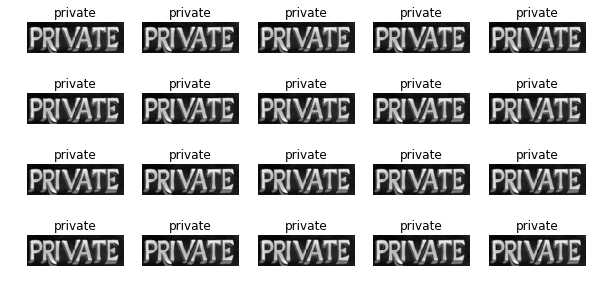

In [369]:
plot_batch_images(x_batch.reshape((len(x_batch), 32,100)), y_batch, name="benoit", predictions=None)

In [370]:
with open('tt_new.pickle', 'rb') as f:
    tt = pickle.load(f)
ngram_transformer = NgramTransform()

In [371]:
def joint_loss(word, cnn_pred, n_grams_pred):
    
    try :
        loss_cnn = np.sum([np.log(cnn_pred[i,word[i]]) for i in range(len(word))])
    except :
        loss_cnn = - np.inf
    
    loss_ngrams = 0
    word_text = word_from_vector(word)
    for i in range(len(word)):
        for n in range(1, min(5, len(word)-i+1)):
            ngrams_text = "".join([word_text[i+l] for l in range(n)])
#             print(ngrams_text)
#             print("Ngrams {}".format(ngrams_text))
            try:
                ngrams_idx = ngram_transformer.vocabulary[ngrams_text]
                loss_ngrams += np.log(n_grams_pred[ngrams_idx])
            except KeyError:
                pass
            
    return loss_cnn + loss_ngrams

In [372]:

# Prepare a fixed size numpy array that matches the expected input
# shape for the model
beam_size = 5
beam = np.zeros(shape=(beam_size, SEQUENCE_LENGTH))

In [373]:
def beam_search(cnn_pred, n_grams_pred):
    new_candidates = []
    # candidates_ini = [np.array([i]) for i ]
    candidate_list = []

    # Char 1 
    char = 0
    for i in range(1, N_CHARS + 1):
        word = np.array([i])
        new_candidates.append(
            (joint_loss(word, cnn_pred, n_grams_pred), i))
    new_candidates.sort(reverse=True)
    candidates = new_candidates[:beam_size]
    candidate_list.append([[e[1]] for e in candidates])

    for char in range(1,SEQUENCE_LENGTH): 
    #     print(char)
        new_candidates = []
        for candidate in candidate_list[char-1]:

            for i in range(1, N_CHARS + 1):
                word = np.array(candidate + [i])

                new_candidates.append(
                    (joint_loss(word, cnn_pred, n_grams_pred), candidate + [i]))
        new_candidates.sort(reverse=True)
        candidates = new_candidates[:beam_size]
        candidate_list.append([e[1] for e in candidates])


    return tt.word_from_vector(candidate_list[22][0])

In [374]:
for i in range(len(x_batch)):
    print(beam_search(cnn_pred[i], n_grams_pred[i]), tt.word_from_matrix(cnn_pred[i]))

/home/benlet/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


privtt                  private                


In [375]:
n_grams_pred.shape

(1, 10000)

In [376]:
n_grams_pred_ = n_grams_pred[0] > 0.01
ngram_transformer.ngram_from_matrix(n_grams_pred_)

['a',
 'at',
 'ate',
 'e',
 'i',
 'iva',
 'ivat',
 'p',
 'pr',
 'pre',
 'pri',
 'priv',
 'r',
 'riv',
 'riva',
 't',
 'te',
 'v',
 'va',
 'vat',
 'vate']

In [377]:
np.sort(n_grams_pred[0])[::-1]

array([  6.87155128e-02,   5.03815524e-02,   4.64980155e-02, ...,
         6.97278237e-27,   5.85632579e-27,   5.41997786e-27], dtype=float32)

In [378]:
top_elements = 20
np.argsort(n_grams_pred[0])[::-1][:top_elements]

array([9516, 6995, 6968, 6987, 9515, 8483,   10, 7515,  661, 6680, 7097,
       1942, 4282, 4279, 3645,  669, 7514, 8562, 9491, 9490])

In [381]:
test = np.zeros(10000)
test[6995] = 1

In [382]:
ngram_transformer.ngram_from_matrix(test)

['priv']

In [222]:
def word_from_vector(word):
    try:
        return ''.join([tt.inv_vocabulary[l] for l in word])
    except KeyError:
        print(word)
        warnings.warn("missing char")

In [68]:
ngram = word_from_vector(word)

KeyError: '111'

In [70]:
ngram_idx = ngram_transformer.vocabulary[ngram]

In [75]:
np.log(n_grams_pred[0, ngram_idx])

-30.799513

In [78]:
min(4,len(word)-0+1)

3

In [80]:
ngram[0]

'w'

In [142]:
word_from_vector(np.array([4]))

'p'